# Approach

- Text Analysis:
Extracted insights from text comments.
Identified common issues mentioned in comments.

1. Understand the calls generated because of following "sources" to reduce enquiry related inquiries and complaints:
- Websites
- Newspaper
- Friends


In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_excel('Contact Center Data.xlsb', engine='pyxlsb')

In [2]:
website_comments = df[df['Source'] == 'Websites']['Comments']
newspaper_comments = df[df['Source'] == 'Newspaper']['Comments']
friends_comments = df[df['Source'] == 'Friends']['Comments']

# Display the first few comments for each source 
print("Websites Comments:")
print(website_comments.head())

print("\nNewspaper Comments:")
print(newspaper_comments.head())

print("\nFriends Comments:")
print(friends_comments.head())

Websites Comments:
1                                            Call drop
2    While assisting with the info, Customer discon...
3    Customer had already ordered for G500 and enqu...
4                                    Call disconnected
5    Customer called to know about sheild warrenty ...
Name: Comments, dtype: object

Newspaper Comments:
6                       Customer had a technical doubt.
9                     Customer had a technical problem.
13    Customer wants to purhchase L430 MTM-24664B4; ...
15    Customer facing technical issue in his operati...
17    Customer enquired about laptop & disconnected ...
Name: Comments, dtype: object

Friends Comments:
66     Customer is looking for a laptop in Z580 with ...
115    Customer had some issue regarding the do gear ...
297                                           Call Drop.
316                    Call DIsconnected while assisting
330                                            Call drop
Name: Comments, dtype: object


# Data Cleaning

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nehagovekar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Function for text preprocessing
def preprocess_text(comment):
    if isinstance(comment, (str, int)):
        comment = str(comment)
        comment = comment.lower()
        comment = ''.join([char for char in comment if char.isalnum() or char.isspace()])
    else:
        # If not a string or integer, return an empty string
        comment = ''

   
    # Tokenize and remove stop words
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(comment)
    words = [word for word in words if word not in stop_words]
    
    # Apply stemming (you can use lemmatization as an alternative)
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    return ' '.join(words)


In [5]:
# Apply text preprocessing
website_comments= website_comments.astype(str)
website_comments_preprocessed = website_comments.apply(preprocess_text)

In [6]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(website_comments_preprocessed)

# Display TF-IDF features (optional)
tfidf_features = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

from gensim import corpora, models

dictionary = corpora.Dictionary([comment.split() for comment in website_comments_preprocessed])
corpus = [dictionary.doc2bow(comment.split()) for comment in website_comments_preprocessed]

lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary)


print("LDA Topics:")
for topic in lda_model.print_topics():
    print(topic)

LDA Topics:
(0, '0.152*"diwali" + 0.106*"custom" + 0.098*"enquir" + 0.093*"offer" + 0.068*"assist" + 0.062*"detail" + 0.044*"info" + 0.040*"given" + 0.027*"lead" + 0.027*"accordingli"')
(1, '0.149*"assist" + 0.102*"custom" + 0.091*"accordingli" + 0.087*"technic" + 0.062*"enquir" + 0.040*"number" + 0.039*"issu" + 0.026*"regad" + 0.026*"depart" + 0.013*"complaint"')
(2, '0.105*"call" + 0.083*"custom" + 0.064*"receiv" + 0.061*"offer" + 0.054*"code" + 0.048*"evouch" + 0.040*"drop" + 0.038*"yet" + 0.038*"redempt" + 0.035*"disconnect"')
(3, '0.133*"custom" + 0.050*"purchas" + 0.046*"buy" + 0.032*"mtm" + 0.031*"g500" + 0.025*"within" + 0.022*"want" + 0.019*"week" + 0.019*"will" + 0.019*"needful"')
(4, '0.125*"custom" + 0.106*"want" + 0.072*"order" + 0.067*"purchas" + 0.034*"product" + 0.033*"statu" + 0.027*"day" + 0.027*"call" + 0.019*"place" + 0.017*"enquir"')


# Website Sentiment Analysis of preprocessed data

In [7]:
import nltk
nltk.download('vader_lexicon')
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from collections import Counter

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nehagovekar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
def analyze_sentiment(comment):
    # Check if the comment is a string or can be converted to a string
    if not isinstance(comment, str):
        comment = str(comment)

    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(comment)['compound']
    return 'Positive' if sentiment_score > 0 else 'Negative' if sentiment_score < 0 else 'Neutral'

In [9]:
def analyze_keywords(comments):
    # Tokenize and count words
    words = [word_tokenize(str(comment)) for comment in comments if isinstance(comment, (str, int))]
    words = [word for sublist in words for word in sublist]  # Flatten the list of lists

    word_counts = Counter(words)
    # Display the most common keywords
    most_common_keywords = word_counts.most_common(10)
    return most_common_keywords

In [10]:
df['website_sentiment'] = website_comments.apply(analyze_sentiment)
df['website_sentiment'].value_counts()

Neutral     54101
Positive     7866
Negative     6980
Name: website_sentiment, dtype: int64

Further analyze:

    - Negative: to decrease call volume by finding out the problem and to enhance customer experience
    - Neutral: To enhance customer experience by understanding why they needed to call for the information
    

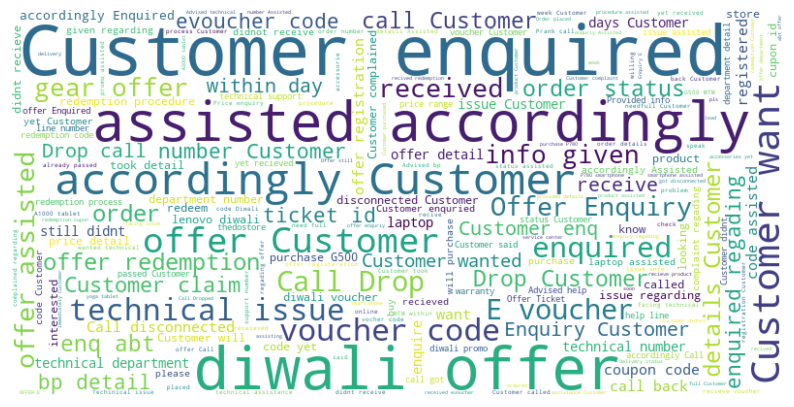

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df['Comments'] = df['Comments'].astype(str)

# Generate a word cloud for comments
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(df['Comments']))

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
print("Sentiment Analysis for Website Comments:")
print(website_comments.value_counts().head(50))

Sentiment Analysis for Website Comments:
Call Drop                                                                                           975
Assisted with offer details.                                                                        752
customer enquired about Offer                                                                       704
Diwali Offer Enquiry                                                                                573
Techinical issue.                                                                                   478
Technical issue.                                                                                    476
Drop call                                                                                           389
Call drop.                                                                                          332
Customer had technical issue info given on same..                                                   331
Offer enquiry          

# Source Website for product_type notebook 

In [13]:
nb_sentiment_type_value_counts = df[(df['Product_Type']== 'Notebook') & (df['website_sentiment']!='')][['Comments', 'website_sentiment']]['website_sentiment'].value_counts()
nb_sentiment_type_value_counts

Neutral     42003
Negative     5981
Positive     5236
Name: website_sentiment, dtype: int64

In [14]:
nb_sentiment_type_value_counts.sum()

53220

In [15]:
round(nb_sentiment_type_value_counts*100/nb_sentiment_type_value_counts.sum(), 2)

Neutral     78.92
Negative    11.24
Positive     9.84
Name: website_sentiment, dtype: float64

- we can see that out of 53220 almost 6000 comments are of negative sentiment with regards to website and notebook related issues
- Notebooks comprise of almost 11% of the website related issues/ calls

# Analysis of Website- Positive, Negative and Neutral

In [16]:
call_Drop = website_comments.str.contains(r'\bcall drop\b|\bdrop call\b|\bdisconnected\b|\bcall got drop\b', case=False, regex=True)
call_Drop.value_counts()

False    64206
True      4741
Name: Comments, dtype: int64

People who called through website had the call disconnected or dropped 4741 times out of which 2903 had a negative sentiment

In [17]:
diwali = website_comments.str.contains(r'\bdiwali\b', case=False, regex=True)
diwali.value_counts()

False    54599
True     14348
Name: Comments, dtype: int64

Calls through website for Diwali were made 14348 times that is almost ~17% of the total calls were for Diwali related offers Out of 14348 calls 1471 calls had negative experience when called about Diwali offers/anything else

In [18]:
technical_issue = website_comments.str.contains(r'\btechnical issue\b', case=False, regex=True)
technical_issue.value_counts()

False    66280
True      2667
Name: Comments, dtype: int64

2667 calls were made for technical issues

In [19]:
voucher = website_comments.str.contains(r'\bE-Voucher\b|\bevoucher\b', case=False, regex=True)
voucher.value_counts()

False    64435
True      4512
Name: Comments, dtype: int64

4512 calls were made for vouchers

# Website Analysis for Negative Comments only

In [20]:
negative_comments = website_comments[df['website_sentiment'] == 'Negative']
print(negative_comments.value_counts().head())

Call Drop     975
Drop call     389
Call drop.    332
Call drop     214
Call Drop.    209
Name: Comments, dtype: int64


Top Reasons for Negative Sentiments from Website

    - Call Drop- will do further analysis why people are dropping or disconnecting the calls
    - Diwali Offers-coupon not recieved, coupon not working, can't redeem coupon
    - E-Vouchers are not working, error while entering the code
    -Technical complaints-Advising Technical Number for (tablet,notebook,laptop)
    

After analyzing sentiment, we saw there are ~7k comments which are negative, we need to do further analysis on why they are negatvie

In [21]:
#Diwali comments for negative sentiments
df['diwali_comments'] = negative_comments.str.contains(r'\bdiwali\b', case=False, regex=True)
df['diwali_comments'].value_counts()

False    5509
True     1471
Name: diwali_comments, dtype: int64

1471 negative sentiments for diwali

In [22]:
#E-Voucher for negative sentiments
df['e_Voucher'] = negative_comments.str.contains(r'\bE-Voucher\b|\bevoucher\b|\bvoucher\b', case=False, regex=True)
df['e_Voucher'].value_counts()

False    5755
True     1225
Name: e_Voucher, dtype: int64

1225 negative sentiments for evoucher 

In [23]:
#"technical number" for negative sentiments
df['technical'] = negative_comments.str.contains(r'\btechnical number\b|\btechnical\b', case=False, regex=True)
df['technical'].value_counts()

False    6569
True      411
Name: technical, dtype: int64

411 negative sentiments for technical issues

In [24]:
#call drop for negative sentiments
call_Drop = negative_comments.str.contains(r'\bcall drop\b|\bdrop call\b|\bdisconnected\b|\bdrop\b|\bcall got drop\b', case=False, regex=True)
call_Drop.value_counts()

False    4271
True     2709
Name: Comments, dtype: int64

2709 negative sentiments for call drop- need further analysis

# Website Sentiment Analysis for Neutral Experience 

In [25]:
neutral_comments = website_comments[df['website_sentiment'] == 'Neutral']
print(neutral_comments.value_counts().head(20))

Assisted with offer details.                                                                 752
customer enquired about Offer                                                                704
Diwali Offer Enquiry                                                                         573
Techinical issue.                                                                            478
Technical issue.                                                                             476
Customer had technical issue info given on same..                                            331
Offer enquiry                                                                                307
Diwali offer enquriy Assisted accordingly.                                                   280
Technical issue have assisted accordingly.                                                   277
Customer didnot receive the accessories yet.                                                 273
Enquired about the Diwali Offe

In [26]:
#Diwali comments for neutral sentiments
df['diwali_comments'] = neutral_comments.str.contains(r'\bdiwali\b', case=False, regex=True)
df['diwali_comments'].value_counts().head()

False    41781
True     12320
Name: diwali_comments, dtype: int64

In [27]:
#E-Voucher for neutral sentiments
df['e_Voucher'] = neutral_comments.str.contains(r'\bE-Voucher\b|\bevoucher\b|\bvoucher\b', case=False, regex=True)
df['e_Voucher'].value_counts()

False    47469
True      6632
Name: e_Voucher, dtype: int64

In [28]:
#"technical number" for neutral sentiments
df['technical'] = neutral_comments.str.contains(r'\btechnical number\b|\btechnical\b', case=False, regex=True)
df['technical'].value_counts()


False    50559
True      3542
Name: technical, dtype: int64

In [29]:
#call drop for neutral sentiments
call_Drop = neutral_comments.str.contains(r'\bcall drop\b|\bdrop call\b|\bdisconnected\b|\bdrop\b', case=False, regex=True)
call_Drop.value_counts()

False    52054
True      2047
Name: Comments, dtype: int64

# Newspaper Sentiment Analysis of preprocessed data

In [30]:
# Apply text preprocessing
newspaper_comments= newspaper_comments.astype(str)
newspaper_comments_preprocessed = newspaper_comments.apply(preprocess_text)

In [31]:
df['newspaper_comments'] = newspaper_comments.apply(analyze_sentiment)
df['newspaper_comments'].value_counts()


Neutral     9451
Negative     988
Positive     681
Name: newspaper_comments, dtype: int64

In [32]:
negative_comments_newspaper = newspaper_comments[df['newspaper_comments'] == 'Negative']
print(negative_comments_newspaper.value_counts().head(30))

Call Drop                                                                                                         169
Call drop.                                                                                                         92
Call drop                                                                                                          62
Drop call                                                                                                          46
call drop                                                                                                          45
Drop call.                                                                                                         33
While assisting call got drop.                                                                                     25
Call Drop.                                                                                                         23
call Drop                                               

Newspaper
 - People calling with the source as newspaper end up dropping the call
 - They call to enquire about different mtm no. (looks like different ads)
 - Call about price details
 - Many call drops while assisting

In [33]:
nb_newspapers_sentiment_type_value_counts = df[(df['Product_Type']== 'Notebook') & (df['newspaper_comments']!='')][['Comments', 'newspaper_comments']]['newspaper_comments'].value_counts()
nb_newspapers_sentiment_type_value_counts

Neutral     6984
Negative     812
Positive     424
Name: newspaper_comments, dtype: int64

In [34]:
nb_newspapers_sentiment_type_value_counts.sum()

8220

In [35]:
round(nb_newspapers_sentiment_type_value_counts*100/nb_newspapers_sentiment_type_value_counts.sum(), 2)

Neutral     84.96
Negative     9.88
Positive     5.16
Name: newspaper_comments, dtype: float64

- we can see that out of 8220 almost 7% comments are of negative sentiment with regards to newspaper and notebook related issues
- Notebooks comprise of almost 10% of the newspaper related issues/ calls

# Friends Sentiment Analysis of preprocessed data

In [36]:
# Apply text preprocessing
friends_comments= friends_comments.astype(str)
friends_comments_preprocessed = friends_comments.apply(preprocess_text)

In [37]:
df['friends_comments'] = friends_comments.apply(analyze_sentiment)
df['friends_comments'].value_counts()


Neutral     2561
Negative     739
Positive     238
Name: friends_comments, dtype: int64

In [38]:
negative_comments_friends = friends_comments[df['friends_comments'] == 'Negative']
print(negative_comments_friends.value_counts().head(20))

Call Drop                                                              306
Drop call.                                                              77
Drop call                                                               72
Call drop                                                               38
call drop                                                               26
Drop call...                                                            16
call Drop                                                               11
No response on call.                                                    11
drop call                                                                9
Call Drop.                                                               8
No response from customer.                                               7
CAll Drop                                                                6
No response                                                              5
Advised technical number 

Friends Analysis
1. Call Drop
2. No response